# Accuracy assessment using September 2021 to January 2022 validation dataset

In [1]:
# Load the required python packages
import json
import os
from pprint import pprint

import matplotlib.pyplot as plt
import pandas as pd
from joblib import load
from odc.io.cgroups import get_cpu_quota
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    accuracy_score,
    classification_report,
    cohen_kappa_score,
    confusion_matrix,
    precision_score,
    recall_score,
)
from utils import get_key

In [2]:
# Set the anlaysis parameters.
output_folder = "results"
model_path = os.path.join(output_folder, "sep_2021_to_jan_2022_ml_model.joblib")

class_labels_path = "clean_data/class_labels.json"

# CSV file containing the training features.
model_input_path = os.path.join(
    output_folder, "sep_2021_to_jan_2022_training_features_validation.csv"
)

In [3]:
# Get the number of cpus available
ncpus = round(get_cpu_quota())
print("ncpus = " + str(ncpus))

ncpus = 15


In [4]:
# Load the model
model = load(model_path).set_params(n_jobs=1)

In [5]:
# Read the class label dictionary
with open(class_labels_path, "r") as json_file:
    class_labels_dict = json.load(json_file)
class_labels_dict

{'Cassava': 0,
 'Common bean': 1,
 'Maize': 2,
 'Maize/Mixed': 3,
 'Soybean': 4,
 'Sugarcane': 5}

In [6]:
# Load the training data
model_input_df = pd.read_csv(model_input_path)
label_col = model_input_df.columns[0]
feature_cols = model_input_df.columns[1:]

# Split the data into features and labels
X = model_input_df[feature_cols].values
y = model_input_df[label_col].values.ravel()

In [7]:
# Read the class label dictionary
with open(class_labels_path, "r") as json_file:
    class_labels_dict = json.load(json_file)
class_labels_dict

{'Cassava': 0,
 'Common bean': 1,
 'Maize': 2,
 'Maize/Mixed': 3,
 'Soybean': 4,
 'Sugarcane': 5}

In [8]:
# Get the class labels and names.
class_labels = model.classes_
class_target_names = [get_key(i, class_labels_dict) for i in class_labels]

In [9]:
# Classify the testing dataset training features using the trained classifier.
y_pred = model.predict(X)

In [10]:
accuracy_metrics = {}

In [11]:
# Get Cohen's kappa score
kappa_score = cohen_kappa_score(y1=y, y2=y_pred)
accuracy_metrics["Kappa Score"] = kappa_score

In [12]:
overall_accuracy = accuracy_score(y_true=y, y_pred=y_pred)
accuracy_metrics["Overall Accuracy"] = overall_accuracy

In [13]:
precision = precision_score(
    y_true=y, y_pred=y_pred, labels=class_labels, average=None
)
producers_accuracy = dict(
    zip([f"Producer's Accuracy for {name}" for name in class_target_names], precision)
)
accuracy_metrics.update(producers_accuracy)

In [14]:
recall = recall_score(y_true=y, y_pred=y_pred, labels=class_labels, average=None)
users_accuracy = dict(
    zip([f"User's Accuracy for {name}" for name in class_target_names], recall)
)
accuracy_metrics.update(users_accuracy)

In [15]:
pprint(accuracy_metrics)

{'Kappa Score': 0.8746118154250849,
 'Overall Accuracy': 0.9370629370629371,
 "Producer's Accuracy for Maize": 0.9276485788113695,
 "Producer's Accuracy for Maize/Mixed": 0.9669421487603306,
 "Producer's Accuracy for Sugarcane": 0.9375,
 "User's Accuracy for Maize": 0.9782016348773842,
 "User's Accuracy for Maize/Mixed": 0.8540145985401459,
 "User's Accuracy for Sugarcane": 0.8823529411764706}


In [16]:
print("Producer's Accuracy is the precision score")
print("User's Accuracy is the recall score")
# Generate the classificaiton report
report = classification_report(
    y_true=y, y_pred=y_pred, labels=class_labels, target_names=class_target_names
)
print(report)

Producer's Accuracy is the precision score
User's Accuracy is the recall score
              precision    recall  f1-score   support

       Maize       0.93      0.98      0.95       367
 Maize/Mixed       0.97      0.85      0.91       137
   Sugarcane       0.94      0.88      0.91        68

    accuracy                           0.94       572
   macro avg       0.94      0.90      0.92       572
weighted avg       0.94      0.94      0.94       572



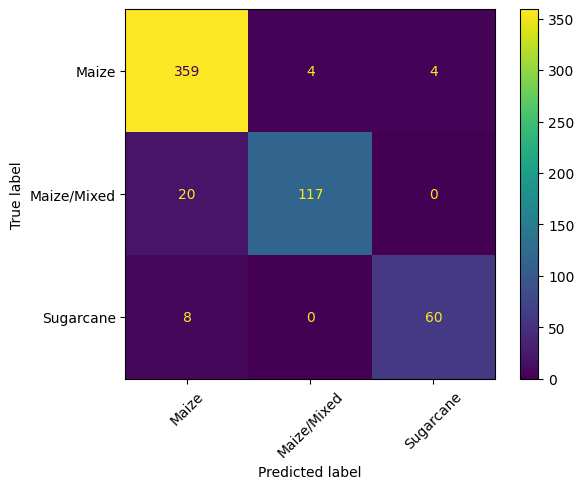

In [17]:
# Display the confusion maxtrix
cm = confusion_matrix(y_true=y, y_pred=y_pred, labels=class_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_target_names)

fig, ax = plt.subplots()
disp.plot(ax=ax)
plt.xticks(rotation=45)# Change xtick labels positions.
plt.show()